Source: https://github.com/mwestt/An-Introduction-to-Bayesian-Inference-in-PyStan

# Introduction

"The many virtues of Bayesian approaches in data science are seldom understated. Unlike the comparatively dusty frequentist tradition that defined statistics in the 20th century, Bayesian approaches match more closely the inference that human brains perform, by combining data-driven likelihoods with prior beliefs about the world. This kind of approach has been fruitfully applied in [reinforcement learning](https://people.eecs.berkeley.edu/~avivt/BRLS_journal.pdf), and efforts to incorporate it into deep learning are a hot area of [current research](https://alexgkendall.com/computer_vision/bayesian_deep_learning_for_safe_ai/). Indeed, it has been [argued](https://link.springer.com/chapter/10.1007/978-94-010-1436-6_6) that Bayesian statistics is the more fundamental of the two statistical schools of thought, and should be the preferred picture of statistics when first introducing students to the subject.

As the predictions from Bayesian inference are probability distributions rather than point estimates, this allows for the quantification of uncertainty in the inferences that are made, which is often missing from the predictions made by machine learning methods.

Although there are clear motivations for incorporating Bayesian approaches into machine learning, there are computational challenges present in actually implementing them. Often, it is not practical to analytically compute the required distributions, and stochastic sampling methods such as [Markov chain Monte Carlo](https://jeremykun.com/2015/04/06/markov-chain-monte-carlo-without-all-the-bullshit/) (MCMC) are used instead. One way of implementing MCMC methods in a transparent and efficient way is via the probabilistic programming language, [Pyro](https://pyro.ai/). 

## Bayes' Theorem

The crux of Bayesian inference is in [Bayes' theorem](https://en.wikipedia.org/wiki/Bayes%27_theorem), which was discovered by the Reverend Thomas Bayes in the 18th century. It's based on a fundamental result from probability theory, which you may have seen before:

$$P(A|B) = \frac{P(B|A)P(A)}{ P(B)}$$

That thing on the left is our posterior, which is the distribution we're interested in. On the right-hand side, we have the likelihood, which is dependent on our model and data, multiplied by the prior, which represents our pre-existing beliefs, and divided by the marginal likelihood which normalises the distribution. 

This theorem can be used to arrive at many counterintuitive results, that are nonetheless true. Take, for instance, the example of [false positives](https://en.wikipedia.org/wiki/Bayes'_theorem#Drug_testing) in drug tests being much higher when the test population is heavily skewed. Rather than go into detail on the basics of Bayesian statistics, I'm going to press onward to discussing inference with Stan. William Koehrsen has some great material for understanding the intuition behind Bayes' theorem [here](https://towardsdatascience.com/bayes-rule-applied-75965e4482ff).

# Motivating the use of a Bayesian Model Framework like Pyro

Bayesian inference is *hard*. The reason for this, according to statistician Don Berry:

> *"Bayesian inference is hard in the sense that thinking is hard." -- Don Berry*

Well, OK. What I suppose he means here is that there's little mathematical overhead that gets in the way of making inferences using Bayesian methods, and so the difficulties come from the problems being conceptually difficult rather than any technical or methodological abstraction. But more concretely, Bayesian inference is hard because *solving integrals is hard*. That $P(B)$ up there involves an integral over all possible values that the model parameters can take. Luckily, we're not totally at a loss, as it is possible to construct an approximation to the posterior distribution by drawing samples from it, and creating a histogram of those sampled values to serve as the desired posterior. 

## MCMC Methods

In generating those samples, we need a methodological framework to govern how the sampler should move through the parameter space. A popular choice is Markov chain Monte Carlo. MCMC is a class of methods that combines two powerful concepts: Markov chains and Monte Carlo sampling. [Markov chains](http://setosa.io/ev/markov-chains/) are stochastic processes that evolve over time in a "memoryless" way, known as the *Markov property*. The Markov property means that the state of a Markov chain transitions to another state with a probability that depends only on the *most recent* state of the system, and not its entire history. Monte Carlo sampling, on other hand, involves solving deterministic problems by repeated random sampling. The canonical way of doing this is with the [Metropolis-Hastings](https://twiecki.github.io/blog/2015/11/10/mcmc-sampling/) algorithm. Stan instead generates these samples using a state-of-the-art algorithm known as Hamiltonian Monte Carlo (HMC), which builds upon the Metropolis-Hastings algorithm by incorporating many theoretical ideas from physics. Actually, by default it implements a version of HMC called the [No-U-Turn Sampler](https://arxiv.org/pdf/1111.4246.pdf) (NUTS). It's easy to get bogged down in the conceptual complexity of these methods, so don't worry if you're not fully on-board at this stage; just internalise that we're generating samples stochastically, and accepting or rejecting those samples based on some probabilistic rule."

[...]
"The first model we'll implement is

$$y \sim \mathcal N\left(\alpha + \beta X, \sigma\right),$$

where we have an intercept $\alpha$ and a gradient $\beta$, and our data $y$ is distributed about this straight line with Gaussian noise of standard deviation $\sigma$."



In [76]:
!pip install pystan

Let's start by importing the relevant packages and setting the numpy seed for reproducibility purposes.

In [ ]:
%matplotlib inline
import pystan
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

sns.set()  # Nice plot aesthetic
np.random.seed(101)

Next, we'll begin our Stan script by specifying our model for the linear regression. The model is written in Stan and assigned to a variable of type string called `model`. This is the only part of the script that needs to by written in Stan, and the inference itself will be done in Python. The code for this model comes from the first example model in  chapter III of the Stan [reference manual](http://mc-stan.org/users/documentation/), which is a recommended read if you're doing any sort of Bayesian inference.

A Stan model requires at least three blocks, for each of data, parameters, and the model. The data block specifies the types and dimensions of the data that will be used for sampling, and the parameter block specifies the relevant parameters. The distribution statement goes in the model block, which in our case is a straight line with additional Gaussian noise. Though not included here, it is also possible to specify transformed data and transformed parameter blocks, as well as blocks for functions and generated quantities.

In [ ]:
model = """
data {
    int<lower=0> N;
    vector[N] x;
    vector[N] y;
}
parameters {
    real alpha;
    real beta;
    real<lower=0> sigma;
}
model {
    y ~ normal(alpha + beta * x, sigma);
}
"""

Notice that in the parameter block, we've specified the lower bound for sigma as 0, as it's impossible for the magnitude of Gaussian noise to be negative. This is an example of a **prior** on the parameter sigma, and more detailed priors can be added in the model block. Notice also that we're not adding any priors to our `alpha` and `beta` parameters, though feel free to experiment with adding priors in the model block and see how they affect the posterior estimates. 

## Data generation

Here we will specify the 'ground truth' values of our parameters which we'll aim to reproduce using Stan, and generate data from these parameters using numpy, making sure to add Gaussian noise. 

Text(0.5,1,'Scatter Plot of Data')

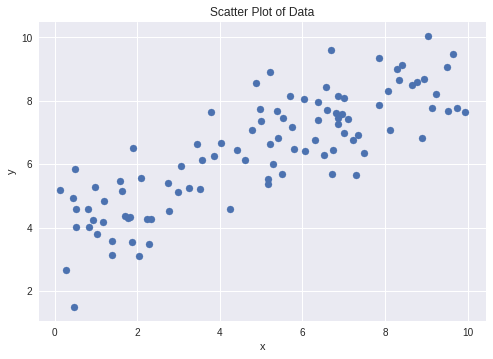

In [79]:
# Parameters to be inferred
alpha = 4.0
beta = 0.5
sigma = 1.0

# Generate and plot data
x = 10 * np.random.rand(100)
y = alpha + beta * x
y = np.random.normal(y, scale=sigma)
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Scatter Plot of Data')

Now we can perform the inference using our PyStan model. The data needs to be in a Python dictionary to run the sampler, and needs a key for every element we specified in the data block of the Stan model. The model then needs to compile before it can be sampled from, though it is possible to load a pre-compiled model instead, which you can do with [this script](https://github.com/mwestt/An-Introduction-to-Bayesian-Inference-in-PyStan/blob/master/PyStan_plotting.py) hosted in the GitHub repository created to accompany this article. This setup allows us to change the data that we want to generate estimates from, without having to recompile the model.

## Sampling

Within the sampling method, there are a number of parameters that can be specified. `iter` refers to the total number of samples that will be generated from each Markov chain, and `chains` is the number of chains from which samples will be combined to form the posterior distribution. Because the underlying Markov process is stochastic, it's advantageous to have more chains that will initialise at different locations in parameter space, though adding more chains will increase the amount of time it takes to sample. `warmup`, also known as 'burn-in' is the amount of samples that will be discarded from the beginning of each chain, as the early samples will be drawn when the Markov chain hasn't had a chance to reach equilibrium. By default this is half of `iter`, so for each chain we'll get 1000 samples, and chuck away the first 500. With 4 chains, we'll have 2000 samples in total.

`thin` specifies an interval in sampling at which samples are retained. So if `thin` is equal to 3, every third sample is retained and the rest are discarded. This can be necessary to mitigate the effect of correlation between successive samples. It's set to 1 here, and so every sample is retained. Finally, `seed` is specified to allow for reproducibility.

In [80]:
# Put our data in a dictionary
data = {'N': len(x), 'x': x, 'y': y}

# Compile the model
sm = pystan.StanModel(model_code=model)

# Train the model and generate samples
fit = sm.sampling(data=data, iter=1000, chains=4, warmup=500, thin=1, seed=101)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cb4cc9c2a04d0e34d711077557307fb7 NOW.
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:367: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /tmp/tmp5oegmm9m/stanfit4anon_model_cb4cc9c2a04d0e34d711077557307fb7_6540548444758960406.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)


Inference for Stan model: anon_model_cb4cc9c2a04d0e34d711077557307fb7.
4 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=2000.

        mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha   3.85  6.3e-3   0.19   3.47   3.73   3.85   3.98   4.22    941    1.0
beta    0.52  1.1e-3   0.03   0.45    0.5   0.52   0.54   0.59    949    1.0
sigma   1.01  2.1e-3   0.07   0.87   0.96    1.0   1.05   1.16   1195    1.0
lp__  -50.62    0.04   1.21 -53.75 -51.14 -50.31 -49.76 -49.26    739   1.01

Samples were drawn using NUTS at Sun Oct 21 09:55:30 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


# Diagnostics

Once sampling is completed, the fit object can be printed to examine the results of the inference. Here we can see summary statistics for our two regression parameters, as well as for the Gaussian noise in our model. Additionally, we can see those same statistics for a quantity called `lp__`, which according to the [Stan manual](http://mc-stan.org/users/documentation/) is the log posterior density up to a constant. Checking that `lp__` has converged allows greater confidence that the whole sampling process has converged, but the value itself isn't particularly important.

In addition to the mean and quantile information, each parameter has two further columns, `n_eff` and `Rhat`. `n_eff` is the [effective sample size](https://en.wikipedia.org/wiki/Effective_sample_size), which because of correlation between samples, can be significantly lower than the nominal amount of samples generated. The effect of [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) can be mitigated by thinning the Markov chains, as described above. `Rhat` is the [Gelman-Rubin](http://digitalassets.lib.berkeley.edu/sdtr/ucb/text/307.pdf) convergence statistic, a measure of Markov chain convergence, and corresponds to the scale factor of variance reduction that could be observed if sampling were allowed to continue forever. So if `Rhat` is approximately 1, you would expect to see no decrease in sampling variance regardless of how long you continue to iterate, and so the Markov chain is likely (but not guaranteed) to have converged.

We can cast this fit output to a pandas DataFrame to make our analysis easier, allowing greater access to the relevant summary statistics. The fit object above has a plot method, but this can be a bit messy and appears to be deprecated. We can instead extract the sequence of sampled values for each parameter, known as a 'trace', which we can plot alongside the corresponding posterior distributions for the purposes of diagnostics.

In [ ]:
summary_dict = fit.summary()
df = pd.DataFrame(summary_dict['summary'], 
                  columns=summary_dict['summary_colnames'], 
                  index=summary_dict['summary_rownames'])

alpha_mean, beta_mean = df['mean']['alpha'], df['mean']['beta']

# Extracting traces
alpha = fit['alpha']
beta = fit['beta']
sigma = fit['sigma']
lp = fit['lp__']

## Plotting our regression line

Now that we've extracted the relevant information from our fitted model, we can look at plotting the results of the linear regression. To get an idea of the kind of spread we can expect to see in our regression line from the uncertainty in the inferred parameters, we can also plot potential regression lines with their parameters sampled from our posteriors.

(-0.5, 10.5)

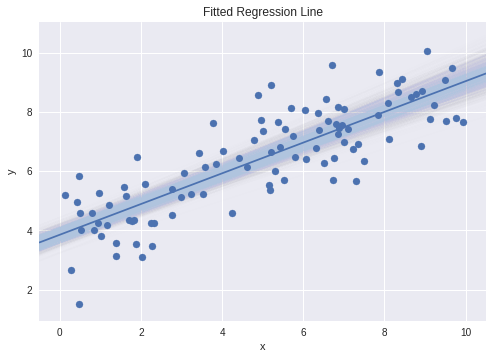

In [82]:
x_min, x_max = -0.5, 10.5
x_plot = np.linspace(x_min, x_max, 100)

# Plot a subset of sampled regression lines
for i in np.random.randint(0, len(alpha), 1000):
    plt.plot(x_plot, alpha[i] + beta[i] * x_plot, color='lightsteelblue',
            alpha=0.005)

# Plot mean regression line  
plt.plot(x_plot, alpha_mean + beta_mean * x_plot)
plt.scatter(x, y)

plt.xlabel('x')
plt.ylabel('y')
plt.title('Fitted Regression Line')
plt.xlim(x_min, x_max)


## Plotting the posteriors

Rather than restricting our analysis to summary statistics, we can also look in more detail at the series of sampled values for each parameter that we extracted previously. This will allow more insight into the sampling process and is an important part of performing fit diagnostics.

Here I've defined a function that plots the trace and posterior distribution for a given parameter.

In [ ]:
def plot_trace(param, param_name='parameter'):
  """Plot the trace and posterior of a parameter."""
  
  # Summary statistics
  mean = np.mean(param)
  median = np.median(param)
  cred_min, cred_max = np.percentile(param, 2.5), np.percentile(param, 97.5)
  
  # Plotting
  plt.subplot(2,1,1)
  plt.plot(param)
  plt.xlabel('samples')
  plt.ylabel(param_name)
  plt.axhline(mean, color='r', lw=2, linestyle='--')
  plt.axhline(median, color='c', lw=2, linestyle='--')
  plt.axhline(cred_min, linestyle=':', color='k', alpha=0.2)
  plt.axhline(cred_max, linestyle=':', color='k', alpha=0.2)
  plt.title('Trace and Posterior Distribution for {}'.format(param_name))

  plt.subplot(2,1,2)
  plt.hist(param, 30, density=True); sns.kdeplot(param, shade=True)
  plt.xlabel(param_name)
  plt.ylabel('density')
  plt.axvline(mean, color='r', lw=2, linestyle='--',label='mean')
  plt.axvline(median, color='c', lw=2, linestyle='--',label='median')
  plt.axvline(cred_min, linestyle=':', color='k', alpha=0.2, label='95% CI')
  plt.axvline(cred_max, linestyle=':', color='k', alpha=0.2)
  
  plt.gcf().tight_layout()
  plt.legend()

Now we can call this function for the purposes of plotting our desired parameters.

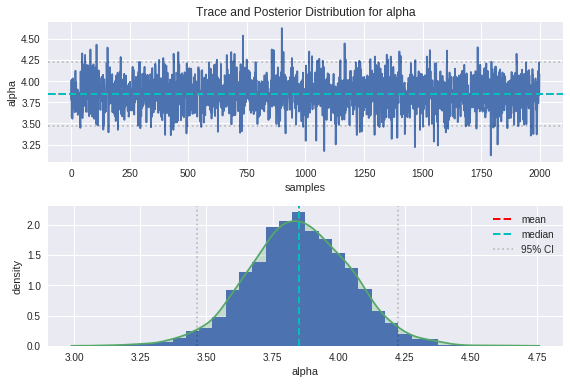

In [84]:
plot_trace(alpha, 'alpha') 

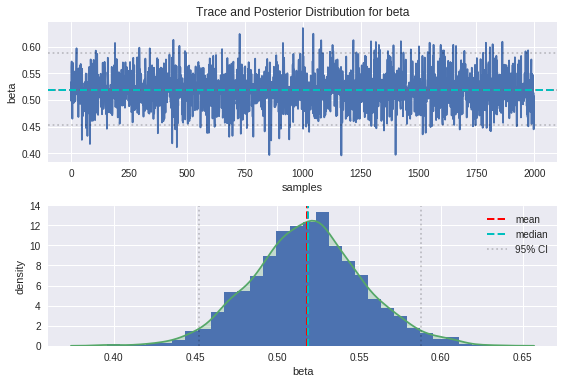

In [85]:
 plot_trace(beta, 'beta')

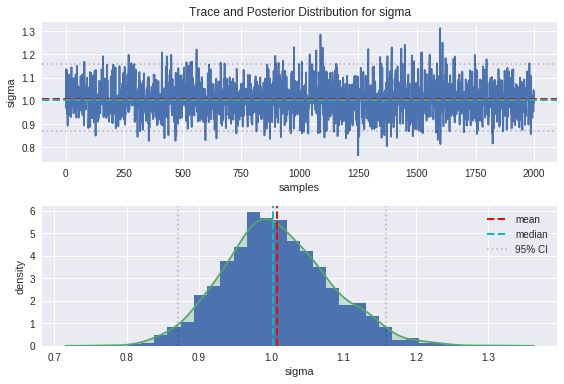

In [86]:
 plot_trace(sigma, 'sigma')

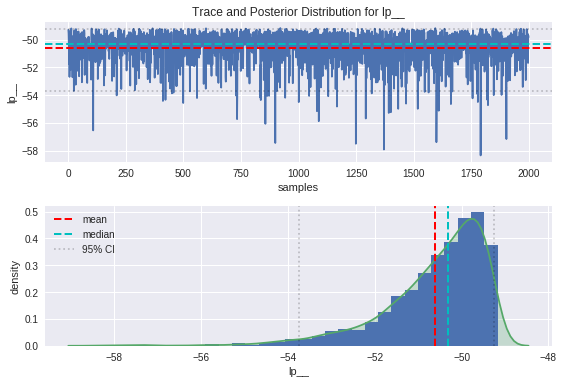

In [87]:
plot_trace(lp, 'lp__')

From the trace plots on top, we can see that the movement through parameter space resembles a random walk, which is indicative that the underlying Markov chain has reached convergence as we would hope.

We can see from the plot of the posterior distributions that the ground truths are on the whole pretty close to the modes of our distributions, and comfortably within the 95% [credible intervals](https://en.wikipedia.org/wiki/Credible_interval). There is some bias between the peaks of the posteriors and the ground truths, which is introduced as a result of the noise in the data. The handy thing about the Bayesian approach is that the uncertainty in estimation is captured in the spread of these posteriors, and can be improved by providing more insightful priors.

# Conclusions

So we've seen how to write a model in Stan, perform sampling using generated data in PyStan, and examine the outputs of the sampling process. Bayesian inference can be extremely powerful, and there are many more features of Stan that remain to be explored. I hope this example has been useful and that you can use some of this material in performing your own sampling and inference.